In [1]:
from SAC.replay_memory import ReplayMemory
from SAC.sac import SAC


agent = SAC("cuda") 
memory = ReplayMemory(1000000)

In [2]:
import gym
import gym_reversi

def opponent(board, avail):
    dummy=np.where(avail==np.amax(avail))
    # dummy=np.where(avail>0)
    maxavail = list(zip(dummy[0],dummy[1]))
    move = random.choice(maxavail)    
    return move


def self_play_opponent(board, avail):
    global env, agent
    state = env.get_state(-env.AI_Player)
    valid_actions = env.get_actions(-env.AI_Player)
    action, _, _= agent.select_action(state, valid_actions, evaluate=True)
    return env.action_ind_to_board_pos(action)

env = gym.make("reversi-v0", opponent = opponent, AI_Player = 1)

In [3]:
import numpy as np
import random

# Evaluate based on playing againts deterministic opponent
def test(num_games):
    global env, agent
    winner_counter = {
        "AI":0,
        "Tie":0,
        "Opponent":0
    }

    tmp = env.opponent
    env.opponent = opponent
    
    for g in range(num_games):
        done = False
        state = env.reset()
        r = 0
        while(not done):
            # env.render()
            valid_actions = env.get_actions(env.AI_Player)
            action, _, _= agent.select_action(state, valid_actions, evaluate=True)
            next_state, reward, done, _ = env.step(action)        
            state = next_state
            r+=reward
        count = np.sum(env.board)
        if count == 0:
            winner = "Tie"
        elif env.AI_Player * count > 0:
            winner = "AI"
        else:
            winner = "Opponent"
        
        winner = "Tie" if reward == 0 else ("AI" if reward > 0 else "Opponent")
        winner_counter[winner] += 1 / num_games
    env.opponent = tmp # reset opponent
    return winner_counter
test(50)

{'AI': 0.7400000000000003, 'Tie': 0.14, 'Opponent': 0.12000000000000001}

In [4]:
import time
import pickle

batch_size = 32
GAMES_PER_EPISODE = 100
EPISODES = 1000

# win_rate_ = win_rate
# tie_rate_ = tie_rate

win_rate = np.zeros(EPISODES)
tie_rate = np.zeros(EPISODES)

# win_rate[:len(win_rate_)] = win_rate_
# tie_rate[:len(tie_rate_)] = tie_rate_

# env.opponent = self_play_opponent
env.opponent = opponent
losses = []

for e in range(EPISODES):
    e_start = time.time()
    for g in range(GAMES_PER_EPISODE):
        done = False
        state = env.reset()
        while(not done):
            # env.render()
            valid_actions = env.get_actions(env.AI_Player)
            action, _, _= agent.select_action(state, valid_actions)

            next_state, reward, done, _ = env.step(action)        
            valid_actions_next = env.get_actions(env.AI_Player)
            
            memory.push(state, action, reward, next_state, done, valid_actions, valid_actions_next)
            state = next_state
            
        if(memory.position > batch_size):
            losses.append(agent.update_parameters(memory, batch_size))
    e_duration = time.time() - e_start
    if e % 10 == 0:
        winner_counter = test(50)

        print("episode: {}/{}, Time:{}: AI: {}, Tie: {}, Opponent: {}".format(e+1, EPISODES,e_duration,
            winner_counter["AI"], winner_counter["Tie"], winner_counter["Opponent"]))        
        win_rate[e] = winner_counter["AI"]
        tie_rate[e] = winner_counter["Tie"]
    else:
        print("episode: {}/{}, Time:{}".format(e+1, EPISODES, e_duration))
    
    # if e % 100 == 0 and e > 0:
    #    agent.save("SPdqn{}_discount1_custAct.h5".format(e))
    
    env.AI_Player *= -1
# agent.save("dqn{}_discount1_custAct.h5".format(EPISODES))
# pickle.dump( agent.memory, open( "SPagentMemory{}_discount1_custAct.p".format(EPISODES), "wb" ) )

episode: 1/1000, Time:37.45744299888611: AI: 0.6200000000000002, Tie: 0.14, Opponent: 0.23999999999999996
episode: 2/1000, Time:34.73809051513672
episode: 3/1000, Time:37.59181523323059
episode: 4/1000, Time:39.81699299812317
episode: 5/1000, Time:38.3704047203064
episode: 6/1000, Time:36.806564807891846
episode: 7/1000, Time:37.95614528656006
episode: 8/1000, Time:36.55768609046936
episode: 9/1000, Time:36.20491123199463
episode: 10/1000, Time:39.29378533363342
episode: 11/1000, Time:38.10135793685913: AI: 0.8000000000000004, Tie: 0.06, Opponent: 0.14
episode: 12/1000, Time:36.081093549728394
episode: 13/1000, Time:38.401081800460815
episode: 14/1000, Time:35.54494023323059
episode: 15/1000, Time:37.15652418136597
episode: 16/1000, Time:40.50879740715027
episode: 17/1000, Time:41.5994975566864
episode: 18/1000, Time:40.885010957717896
episode: 19/1000, Time:40.44194269180298
episode: 20/1000, Time:42.22199869155884
episode: 21/1000, Time:40.7761595249176: AI: 0.6600000000000003, Tie: 

episode: 174/1000, Time:48.91044592857361
episode: 175/1000, Time:50.97822451591492
episode: 176/1000, Time:49.177809953689575
episode: 177/1000, Time:50.91103386878967
episode: 178/1000, Time:50.430779457092285
episode: 179/1000, Time:51.168493032455444
episode: 180/1000, Time:50.36912775039673
episode: 181/1000, Time:49.966153144836426: AI: 0.7400000000000003, Tie: 0.08, Opponent: 0.18
episode: 182/1000, Time:50.07330918312073
episode: 183/1000, Time:50.887274980545044
episode: 184/1000, Time:50.25708079338074
episode: 185/1000, Time:50.33906316757202
episode: 186/1000, Time:48.32618069648743
episode: 187/1000, Time:50.67671537399292
episode: 188/1000, Time:50.608500242233276
episode: 189/1000, Time:50.05422306060791
episode: 190/1000, Time:50.38952088356018
episode: 191/1000, Time:50.57984232902527: AI: 0.8200000000000004, Tie: 0.04, Opponent: 0.14
episode: 192/1000, Time:49.07701754570007
episode: 193/1000, Time:51.9304256439209
episode: 194/1000, Time:48.333972692489624
episode: 1

episode: 345/1000, Time:53.60890054702759
episode: 346/1000, Time:52.37032127380371
episode: 347/1000, Time:52.053850412368774
episode: 348/1000, Time:52.99490785598755
episode: 349/1000, Time:53.39915919303894
episode: 350/1000, Time:52.477227210998535
episode: 351/1000, Time:53.51381826400757: AI: 0.9200000000000005, Tie: 0.04, Opponent: 0.04
episode: 352/1000, Time:52.24841833114624
episode: 353/1000, Time:52.98137927055359
episode: 354/1000, Time:52.489601612091064
episode: 355/1000, Time:53.88489818572998
episode: 356/1000, Time:52.09637475013733
episode: 357/1000, Time:53.971153259277344
episode: 358/1000, Time:52.236342668533325
episode: 359/1000, Time:53.64415001869202
episode: 360/1000, Time:51.886839151382446
episode: 361/1000, Time:53.02501392364502: AI: 0.8400000000000004, Tie: 0.08, Opponent: 0.08
episode: 362/1000, Time:52.27620315551758
episode: 363/1000, Time:54.08606243133545
episode: 364/1000, Time:52.50742244720459
episode: 365/1000, Time:53.80940222740173
episode: 3

episode: 517/1000, Time:51.90373373031616
episode: 518/1000, Time:52.41136884689331
episode: 519/1000, Time:51.73599648475647
episode: 520/1000, Time:52.409701347351074
episode: 521/1000, Time:52.02215933799744: AI: 0.8000000000000004, Tie: 0.08, Opponent: 0.12000000000000001
episode: 522/1000, Time:53.10325288772583
episode: 523/1000, Time:52.36044192314148
episode: 524/1000, Time:52.40389895439148
episode: 525/1000, Time:53.7273805141449
episode: 526/1000, Time:52.497045040130615
episode: 527/1000, Time:51.57327651977539
episode: 528/1000, Time:52.55342650413513
episode: 529/1000, Time:52.41848874092102
episode: 530/1000, Time:52.264007568359375
episode: 531/1000, Time:49.357810735702515: AI: 0.9000000000000005, Tie: 0.04, Opponent: 0.06
episode: 532/1000, Time:52.52556133270264
episode: 533/1000, Time:51.89961886405945
episode: 534/1000, Time:51.14837574958801
episode: 535/1000, Time:51.611167907714844
episode: 536/1000, Time:52.48482012748718
episode: 537/1000, Time:52.374285936355

episode: 687/1000, Time:51.35238766670227
episode: 688/1000, Time:50.643559217453
episode: 689/1000, Time:51.07989168167114
episode: 690/1000, Time:49.611347913742065
episode: 691/1000, Time:52.01494240760803: AI: 0.7800000000000004, Tie: 0.08, Opponent: 0.14
episode: 692/1000, Time:49.809515714645386
episode: 693/1000, Time:50.19002437591553
episode: 694/1000, Time:50.30976343154907
episode: 695/1000, Time:51.629894733428955
episode: 696/1000, Time:50.11049675941467
episode: 697/1000, Time:53.017139196395874
episode: 698/1000, Time:50.86383771896362
episode: 699/1000, Time:51.56999444961548
episode: 700/1000, Time:50.23740005493164
episode: 701/1000, Time:51.30494666099548: AI: 0.7600000000000003, Tie: 0.06, Opponent: 0.18
episode: 702/1000, Time:49.89047574996948
episode: 703/1000, Time:51.72529673576355
episode: 704/1000, Time:50.5731520652771
episode: 705/1000, Time:52.62528347969055
episode: 706/1000, Time:50.08894228935242
episode: 707/1000, Time:51.68570423126221
episode: 708/10

episode: 859/1000, Time:52.959418296813965
episode: 860/1000, Time:49.01649188995361
episode: 861/1000, Time:51.15056395530701: AI: 0.7800000000000004, Tie: 0.04, Opponent: 0.18
episode: 862/1000, Time:50.451597929000854
episode: 863/1000, Time:51.237555742263794
episode: 864/1000, Time:50.69089078903198
episode: 865/1000, Time:51.30557036399841
episode: 866/1000, Time:49.83421730995178
episode: 867/1000, Time:52.35353469848633
episode: 868/1000, Time:50.79197335243225
episode: 869/1000, Time:52.31161427497864
episode: 870/1000, Time:49.08856511116028
episode: 871/1000, Time:50.90014314651489: AI: 0.8400000000000004, Tie: 0.02, Opponent: 0.14
episode: 872/1000, Time:49.81951332092285
episode: 873/1000, Time:51.35434865951538
episode: 874/1000, Time:50.46322011947632
episode: 875/1000, Time:51.91389465332031
episode: 876/1000, Time:49.48165464401245
episode: 877/1000, Time:52.65319776535034
episode: 878/1000, Time:50.31795597076416
episode: 879/1000, Time:51.46100687980652
episode: 880/

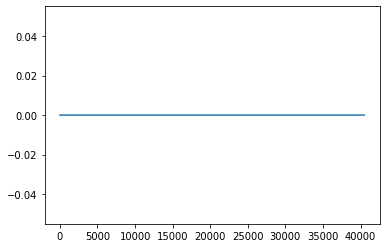

In [9]:
import matplotlib.pyplot as plt
plt.plot([l[3] for l in losses])
plt.show()

In [28]:
pickle.dump( memory, open( "SACMemoryFINAL{}.p".format(1000), "wb" ) )

MemoryError: 

In [5]:
pickle.dump( win_rate, open( "SACWinRateFINAL{}.p".format(1000), "wb" ) )
pickle.dump( tie_rate, open( "SACTieRateFINAL{}.p".format(1000), "wb" ) )

In [17]:
# win_rate_ = pickle.load( open( "SACWinRate2000.p", "rb" ) )
# tie_rate_ = pickle.load( open( "SACWinRate2000.p", "rb" ) )

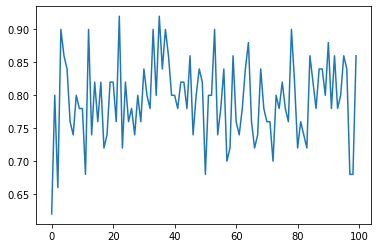

In [12]:
import matplotlib.pyplot as plt
plt.plot(win_rate[win_rate > 0])
# plt.savefig("sacWinRate1000-2000.png")
plt.show()

In [32]:
# env.AI_Player *= -1

test(50)


{'AI': 0.8400000000000004, 'Tie': 0, 'Opponent': 0.16}

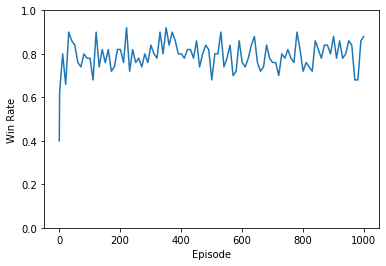

In [27]:
plt.plot(range(EPISODES), win_rate)
plt.ylim([0,1])
plt.xlabel("Episode")
plt.ylabel("Win Rate")
plt.savefig("SAC/WinRateFinal.png", format="png")

In [29]:
agent.save_model("Reversi")

Saving models to models/sac_actor_Reversi_ and models/sac_critic_Reversi_


In [35]:
pickle.dump( losses, open( "SACLossesFINAL{}.p".format(1000), "wb" ) )